# Goal

The main idea is to apply the word-to-vector and Bert tokenizer to classify the reports when we do not have the label for each document. It mainly consists of three parts. Firstly, we clean the texts and embed them into the vector space. Secondly, we create a keyword list for each cluster and embed it into the vector space. Finally, we calculate the similarity scores between every list of text vectors and the keyword vectors, and assign each document to the closest cluster.

# Imports

In [4]:
import gensim
import gensim.downloader as gensim_api  ## for w2v
import json   ## for data 
import math
import matplotlib.pyplot as plt
import nltk  ## for processing
import numpy as np
import pandas as pd
import re
import seaborn as sns
from sklearn import metrics, manifold
import transformers  ## for bert

# Data Preparation

In [6]:
class Data_Preparation:
    """This class binds all preparation work on data, including reading, cleaning, and preprocessing. """
    
    def Read_CSV(self, file_name='/Users/chris/Downloads/real whole corpus.csv'):
        """
        this function is for reading data from csv file, cleaning a little, and return it. 
        Parameter: file_name end with .csv, default value is our real whole corpus.csv file
        Return: a dataframe named corpus
        """
        
        corpus = pd.read_csv(file_name, names = ['company', 'text'])

        for i in range(len(corpus)):
            if corpus.loc[i, 'text'] == ' ':
                corpus.loc[i, 'text'] = np.nan

        corpus = corpus.dropna()
        return corpus
    
    
    def Utils_Preprocess_Text(self, text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
        """
        Preprocess a string.
        Parameters:
            text: string - name of column containing text
            lst_stopwords: list - list of stopwords to remove
            flg_stemm: bool - whether stemming is to be applied
            flg_lemm: bool - whether lemmitisation is to be applied
        Return:
            cleaned text
        """
        ## clean (convert to lowercase and remove punctuations and characters and then strip)
        text = re.sub(r'[^\w\s]', '', str(text).lower().strip())

        ## Tokenize (convert from string to list)
        lst_text = text.split()

        ## remove Stopwords
        if lst_stopwords is not None:
            lst_text = [word for word in lst_text if word not in lst_stopwords]

        ## Stemming (remove -ing, -ly, ...)
        if flg_stemm == True:
            ps = nltk.stem.porter.PorterStemmer()
            lst_text = [ps.stem(word) for word in lst_text]

        ## Lemmatisation (convert the word into root word)
        if flg_lemm == True:
            lem = nltk.stem.wordnet.WordNetLemmatizer()
            lst_text = [lem.lemmatize(word) for word in lst_text]

        ## back to string from list
        text = " ".join(lst_text)
        
        return text
    

new_instance = Data_Preparation()
corpus = new_instance.Read_CSV()
lst_stopwords = nltk.corpus.stopwords.words("english")
corpus["text_clean"] = corpus["text"].apply(lambda x: new_instance.Utils_Preprocess_Text(x, flg_stemm=False, flg_lemm=True,
                                                                    lst_stopwords=lst_stopwords))

# Create target clusters

In [ ]:
class Clustering:
    """This class defined target clusters. """
    
    ## a pretrained NLP model 
    nlp = gensim_api.load("glove-wiki-gigaword-300")
    
    ## Define the keyword list for each cluster
    general_words = ['climate','risk','carbon','emission','environment','social','governance','dioxide','sustainability',
                     'green','economy','energy','efficiency','clean','waste','recuperation','renewable','wind','hydro',
                     'solar','global','warming','hydrocarbon','methane','oil','coal','gas','greenhouse','recycling',
                     'composting','soil','water','air','pollution','natural','hazard']

    physical_words =  ['heat','wave','cold','floods','droughts','wildfires','storms','change','precipitation','pattern',
                       'sea','level','rise','coastal','hazard','fluvial']

    transition_words = ['paris','agreement','regulatory','kyoto','protocol','environmental','protection','agency'] 


    def Get_Similar_Words(self, lst_words, top, nlp):
        """
        This function is used to create a list of keywords for each category. 
        Parameters: lst_words, top_n most similar words, nlp model. 
        Return: a list form of top n keywords for a given list of words. 
        """
        lst_out = lst_words
        for tupla in nlp.most_similar(lst_words, topn=top):
            lst_out.append(tupla[0])
        return list(set(lst_out))

    
cluster_instance = Clustering()
## create dictionary of this form: {category: [keywords]}
dic_clusters = {}
dic_clusters["GENERAL"] = cluster_instance.Get_Similar_Words(cluster_instance.general_words, top=20, nlp=cluster_instance.nlp)
dic_clusters["PHYSICAL"] = cluster_instance.Get_Similar_Words(cluster_instance.physical_words, top=20, nlp=cluster_instance.nlp)
dic_clusters["TRANSITION"] = cluster_instance.Get_Similar_Words(cluster_instance.transition_words, top=20, nlp=cluster_instance.nlp)

## print some
for k,v in dic_clusters.items():
    print(k, ": ", v[0:5], "...", len(v))

[==================================================] 100.0% 376.1/376.1MB downloaded


In [6]:
## a pretrained NLP model 
nlp = gensim_api.load("glove-wiki-gigaword-300")

In [7]:
## Define the keyword list for each cluster
general_words = ['climate','risk','carbon','emission','environment','social','governance','dioxide','sustainability',
                 'green','economy','energy','efficiency','clean','waste','recuperation','renewable','wind','hydro',
                 'solar','global','warming','hydrocarbon','methane','oil','coal','gas','greenhouse','recycling',
                 'composting','soil','water','air','pollution','natural','hazard']

physical_words =  ['heat','wave','cold','floods','droughts','wildfires','storms','change','precipitation','pattern',
                   'sea','level','rise','coastal','hazard','fluvial']

transition_words = ['paris','agreement','regulatory','kyoto','protocol','environmental','protection','agency'] 

In [8]:
## use this to create a dictionary of keywords for each category 

## functionalize 
def get_similar_words(lst_words, top, nlp):
    lst_out = lst_words
    for tupla in nlp.most_similar(lst_words, topn=top):
        lst_out.append(tupla[0])
    return list(set(lst_out))

## create dictionary of this form: {category: [keywords]}
dic_clusters = {}
dic_clusters["GENERAL"] = get_similar_words(general_words, top=20, nlp=nlp)
dic_clusters["PHYSICAL"] = get_similar_words(physical_words, top=20, nlp=nlp)
dic_clusters["TRANSITION"] = get_similar_words(transition_words, top=20, nlp=nlp)

## print some
for k,v in dic_clusters.items():
    print(k, ": ", v[0:5], "...", len(v))

GENERAL :  ['composting', 'emissions', 'sustainable', 'recycling', 'social'] ... 56
PHYSICAL :  ['sea', 'hazard', 'drought', 'floods', 'precipitation'] ... 36
TRANSITION :  ['deal', 'agreements', 'treaty', 'plan', 'commission'] ... 28


# Visualization

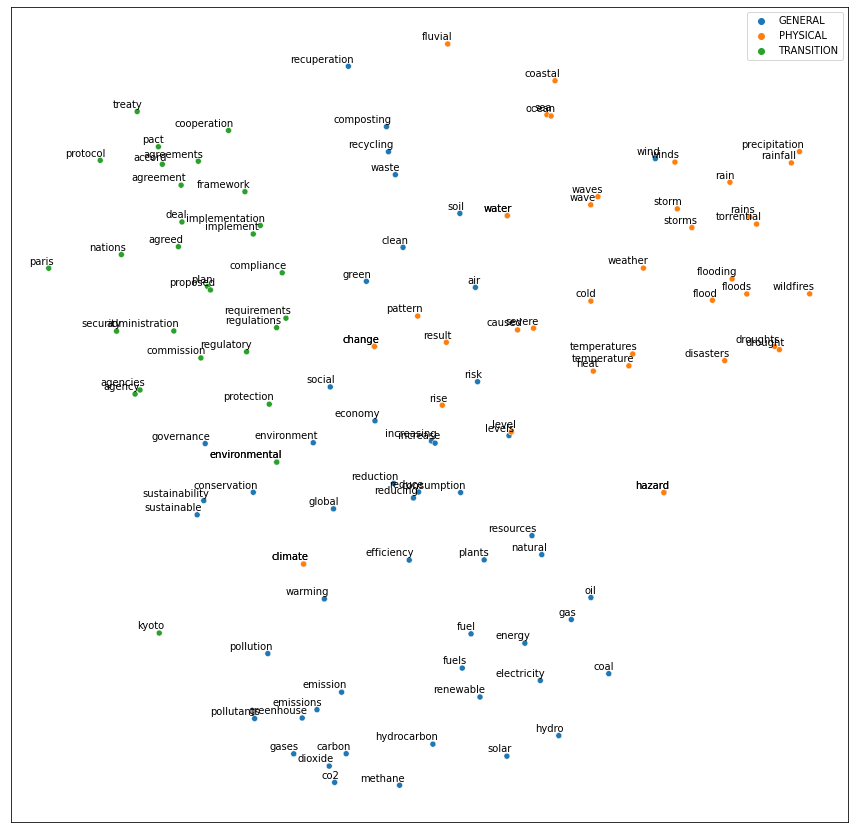

In [9]:
"""This part is to create a visualization of keywords by applying a dimensionality reduction 
algorithm (TSNE), and the more separated of each cluster, the better the result."""

## word embedding
tot_words = [word for v in dic_clusters.values() for word in v]
X = nlp[tot_words]
        
## pca
pca = manifold.TSNE(perplexity=40, n_components=2, init='pca')
X = pca.fit_transform(X)

## create dtf
dtf = pd.DataFrame()
for k,v in dic_clusters.items():
    size = len(dtf) + len(v)
    dtf_group = pd.DataFrame(X[len(dtf):size], columns=["x","y"], index=v)
    dtf_group["cluster"] = k
    dtf = dtf.append(dtf_group)
        
## plot
fig,ax = plt.subplots()
fig.set_figheight(15)
fig.set_figwidth(15)
sns.scatterplot(data=dtf, x="x", y="y", hue="cluster", ax=ax)
ax.legend()
ax.set(xlabel=None, ylabel=None, xticks=[], xticklabels=[], yticks=[], yticklabels=[])
for i in range(len(dtf)):
    ax.annotate(dtf.index[i], xy=(dtf["x"].iloc[i], dtf["y"].iloc[i]), xytext=(5,2), textcoords='offset points',
                ha='right', va='bottom')

# Feature engineering

In [ ]:
class Embedding:
    """ This class defines feature engineering part, which in our case, is embedding the 
    corpus that has been preprocessed and the target clusters created in the same vector space."""
    
    tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
    nlp = transformers.TFBertModel.from_pretrained('bert-base-uncased')
    
    def Utils_Bert_Embedding(self, txt, tokenizer, nlp):
        """
        Embedding function
        
        Parameters: txt, tokenizer, nlp model
        Return: embedding vector
        """
        idx = tokenizer.encode(txt)
        idx = np.array(idx)[None,:]  
        embedding = nlp(idx)
        X = np.array(embedding[0][0][1:-1])
        return X

    
embedding_instance = Embedding()
lst_mean_vecs = []
for i in range(len(corpus)):
    words = corpus['text_clean'].iloc[i].split(' ')

    mean_vecs = []
    for j in range(math.floor(len(words)/20)):
        txt = ' '.join(words[(20*j):(20*(j+1))])
        mean_vecs.append(embedding_instance.Utils_Bert_Embedding(txt, embedding_instance.tokenizer, embedding_instance.nlp).mean(0))
        print(i, j)
    
    np.save('document_' + str(i) + '.npy', mean_vecs)
    lst_mean_vecs.append(mean_vecs)
        
X = np.array(lst_mean_vecs, dtype=object)

In [ ]:
dic_y = {k: embedding_instancce.Utils_Bert_Embedding(v, embedding_instance.tokenizer, embedding_instance.nlp).mean(0) for k,v in dic_clusters.items()}


Sliding window

In [ ]:
## function to apply
def utils_bert_embedding(txt, tokenizer, nlp):
    idx = tokenizer.encode(txt, stride = 10, return_overflowing_tokens=True, max_length = 500)[:-1]
    idx = np.array(idx, dtype=np.int64)
    embedding = nlp(idx)

    X = np.array(embedding[0][0][1:-1])
    for i in range(1, len(embedding[0])):
        X = np.concatenate((X, np.array(embedding[0][i][1:-1])), axis=0)
    return X
## create list of news vector
# lst_mean_vecs = [utils_bert_embedding(txt, tokenizer, nlp).mean(0) for txt in corpus["text_clean"]]
text_clean = corpus["text_clean"].reset_index(drop=True).copy()[0:50] #run for a small sample
lst_mean_vecs = []
for i in range(len(corpus["text_clean"])):
    txt = text_clean.iloc[i]
    try:
        item = utils_bert_embedding(txt, tokenizer, nlp).mean(0)
        lst_mean_vecs.append(item)
        print(i)
    except:
        
        lst_mean_vecs.append(np.zeros(item.shape))
        print('error',i)
        
        



In [26]:
# lst_mean_vecs = []
# for i in range(700, 750):
#     mean_vecs = np.load('document_' + str(i) + '.npy')   -- 可以用来load embedding
#     if mean_vecs.size == 0:
#         print(i)
#     lst_mean_vecs.append(mean_vecs)
# X = np.array(lst_mean_vecs, dtype=object)

In [12]:
# lst_mean_vecs = []
# #for i in range(len(corpus)):
# for i in range(50):
#     words = corpus['text_clean'].iloc[i].split(' ')

#     mean_vecs = []
#     for j in range(math.floor(len(words)/50)):
#         txt = ' '.join(words[(50*j):(50*(j+1))])       -- length变50，只跑了50个，有结果
#         mean_vecs.append(utils_bert_embedding(txt, tokenizer, nlp).mean(0))
#         print(i, j)
    
#     np.save('document_' + str(i) + '(50).npy', mean_vecs)
#     lst_mean_vecs.append(mean_vecs)
        
# X = np.array(lst_mean_vecs, dtype=object)

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0 56
0 57
0 58
0 59
0 60
0 61
0 62
0 63
0 64
0 65
0 66
0 67
0 68
0 69
0 70
0 71
0 72
0 73
0 74
0 75
0 76
0 77
0 78
0 79
0 80
0 81
0 82
0 83
0 84
0 85
0 86
0 87
0 88
0 89
0 90
0 91
0 92
0 93
0 94
0 95
0 96
0 97
0 98
0 99
0 100
0 101
0 102
0 103
0 104
0 105
0 106
0 107
0 108
0 109
0 110
0 111
0 112
0 113
0 114
0 115
0 116
0 117
0 118
0 119
0 120
0 121
0 122
0 123
0 124
0 125
0 126
0 127
0 128
0 129
0 130
0 131
0 132
0 133
0 134
0 135
0 136
0 137
0 138
0 139
0 140
0 141
0 142
0 143
0 144
0 145
0 146
0 147
0 148
0 149
0 150
0 151
0 152
0 153
0 154
0 155
0 156
0 157
0 158
0 159
0 160
0 161
0 162
0 163
0 164
0 165
0 166
0 167
0 168
0 169
0 170
0 171
0 172
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 

3 1150
3 1151
3 1152
3 1153
3 1154
3 1155
3 1156
3 1157
3 1158
3 1159
3 1160
3 1161
3 1162
3 1163
3 1164
3 1165
3 1166
3 1167
3 1168
3 1169
3 1170
3 1171
3 1172
3 1173
3 1174
3 1175
3 1176
3 1177
3 1178
3 1179
3 1180
3 1181
3 1182
3 1183
3 1184
3 1185
3 1186
3 1187
3 1188
3 1189
3 1190
3 1191
3 1192
3 1193
3 1194
3 1195
3 1196
3 1197
3 1198
3 1199
3 1200
3 1201
3 1202
3 1203
3 1204
3 1205
3 1206
3 1207
3 1208
3 1209
3 1210
3 1211
3 1212
3 1213
3 1214
3 1215
3 1216
3 1217
3 1218
3 1219
3 1220
3 1221
3 1222
3 1223
3 1224
3 1225
3 1226
3 1227
3 1228
3 1229
3 1230
3 1231
3 1232
3 1233
3 1234
3 1235
3 1236
3 1237
3 1238
3 1239
3 1240
3 1241
3 1242
3 1243
3 1244
3 1245
3 1246
3 1247
3 1248
3 1249
3 1250
3 1251
3 1252
3 1253
3 1254
3 1255
3 1256
3 1257
3 1258
3 1259
3 1260
3 1261
3 1262
3 1263
3 1264
3 1265
3 1266
3 1267
3 1268
3 1269
3 1270
3 1271
3 1272
3 1273
3 1274
3 1275
3 1276
3 1277
3 1278
3 1279
3 1280
3 1281
3 1282
3 1283
3 1284
3 1285
3 1286
3 1287
3 1288
3 1289
3 1290
3 1291
3 1292

3 2322
3 2323
3 2324
3 2325
3 2326
3 2327
3 2328
3 2329
3 2330
3 2331
3 2332
3 2333
3 2334
3 2335
3 2336
3 2337
3 2338
3 2339
3 2340
3 2341
3 2342
3 2343
3 2344
3 2345
3 2346
3 2347
3 2348
3 2349
3 2350
3 2351
3 2352
3 2353
3 2354
3 2355
3 2356
3 2357
3 2358
3 2359
3 2360
3 2361
3 2362
3 2363
3 2364
3 2365
3 2366
3 2367
3 2368
3 2369
3 2370
3 2371
3 2372
3 2373
3 2374
3 2375
3 2376
3 2377
3 2378
3 2379
3 2380
3 2381
3 2382
3 2383
3 2384
3 2385
3 2386
3 2387
3 2388
3 2389
3 2390
3 2391
3 2392
3 2393
3 2394
3 2395
3 2396
3 2397
3 2398
3 2399
3 2400
3 2401
3 2402
3 2403
3 2404
3 2405
3 2406
3 2407
3 2408
3 2409
3 2410
3 2411
3 2412
3 2413
3 2414
3 2415
3 2416
3 2417
3 2418
3 2419
3 2420
3 2421
3 2422
3 2423
3 2424
3 2425
3 2426
3 2427
3 2428
3 2429
3 2430
3 2431
3 2432
3 2433
3 2434
3 2435
3 2436
3 2437
3 2438
3 2439
3 2440
3 2441
3 2442
3 2443
3 2444
3 2445
3 2446
3 2447
3 2448
3 2449
3 2450
3 2451
3 2452
3 2453
3 2454
3 2455
3 2456
3 2457
3 2458
3 2459
3 2460
3 2461
3 2462
3 2463
3 2464

15 46
15 47
15 48
15 49
15 50
15 51
15 52
15 53
15 54
15 55
16 0
16 1
16 2
16 3
16 4
16 5
16 6
16 7
16 8
16 9
16 10
16 11
16 12
16 13
16 14
16 15
16 16
16 17
16 18
16 19
16 20
16 21
16 22
16 23
16 24
16 25
16 26
16 27
16 28
16 29
16 30
16 31
16 32
16 33
16 34
16 35
16 36
16 37
16 38
16 39
16 40
16 41
16 42
16 43
16 44
16 45
16 46
16 47
16 48
16 49
16 50
16 51
16 52
16 53
16 54
16 55
16 56
16 57
16 58
16 59
16 60
16 61
16 62
16 63
16 64
16 65
16 66
16 67
16 68
16 69
16 70
16 71
16 72
16 73
16 74
16 75
16 76
16 77
16 78
16 79
16 80
16 81
16 82
16 83
16 84
16 85
16 86
16 87
16 88
16 89
16 90
16 91
16 92
16 93
16 94
16 95
16 96
16 97
16 98
16 99
16 100
16 101
16 102
16 103
16 104
16 105
16 106
16 107
16 108
16 109
16 110
16 111
16 112
16 113
16 114
16 115
16 116
16 117
16 118
16 119
16 120
16 121
16 122
16 123
16 124
16 125
16 126
16 127
16 128
16 129
16 130
16 131
16 132
16 133
16 134
16 135
16 136
16 137
16 138
16 139
16 140
16 141
16 142
16 143
16 144
16 145
16 146
16 147
16 148
16 149


24 142
24 143
24 144
24 145
24 146
24 147
24 148
24 149
24 150
24 151
24 152
24 153
24 154
24 155
24 156
24 157
24 158
24 159
24 160
24 161
24 162
24 163
24 164
24 165
24 166
24 167
24 168
24 169
24 170
24 171
24 172
24 173
24 174
24 175
24 176
24 177
24 178
24 179
24 180
24 181
24 182
24 183
24 184
24 185
24 186
24 187
24 188
24 189
24 190
24 191
24 192
24 193
24 194
24 195
24 196
24 197
24 198
24 199
24 200
24 201
24 202
24 203
24 204
24 205
24 206
24 207
24 208
24 209
24 210
24 211
24 212
24 213
24 214
24 215
24 216
24 217
24 218
24 219
24 220
24 221
24 222
24 223
24 224
24 225
24 226
24 227
24 228
24 229
24 230
24 231
24 232
24 233
24 234
24 235
24 236
24 237
24 238
24 239
24 240
24 241
24 242
24 243
24 244
24 245
24 246
24 247
24 248
24 249
24 250
24 251
24 252
24 253
24 254
24 255
24 256
24 257
24 258
24 259
24 260
24 261
24 262
24 263
24 264
24 265
24 266
24 267
24 268
24 269
24 270
24 271
24 272
24 273
24 274
24 275
24 276
24 277
24 278
24 279
24 280
24 281
24 282
24 283
24 284

25 1006
25 1007
25 1008
25 1009
25 1010
25 1011
25 1012
25 1013
25 1014
25 1015
25 1016
25 1017
25 1018
25 1019
25 1020
25 1021
25 1022
25 1023
25 1024
25 1025
25 1026
25 1027
25 1028
25 1029
25 1030
25 1031
25 1032
25 1033
25 1034
25 1035
25 1036
25 1037
25 1038
25 1039
25 1040
25 1041
25 1042
25 1043
25 1044
25 1045
25 1046
25 1047
25 1048
25 1049
25 1050
25 1051
25 1052
25 1053
25 1054
25 1055
25 1056
25 1057
25 1058
25 1059
25 1060
25 1061
25 1062
25 1063
25 1064
25 1065
25 1066
25 1067
25 1068
25 1069
25 1070
25 1071
25 1072
25 1073
25 1074
25 1075
25 1076
25 1077
25 1078
25 1079
25 1080
25 1081
25 1082
25 1083
25 1084
25 1085
25 1086
25 1087
25 1088
25 1089
25 1090
25 1091
25 1092
25 1093
25 1094
25 1095
25 1096
25 1097
25 1098
25 1099
25 1100
25 1101
25 1102
25 1103
25 1104
25 1105
25 1106
25 1107
25 1108
25 1109
25 1110
25 1111
25 1112
25 1113
25 1114
25 1115
25 1116
25 1117
25 1118
25 1119
25 1120
25 1121
25 1122
25 1123
25 1124
25 1125
25 1126
25 1127
25 1128
25 1129
25 1130


35 669
35 670
35 671
35 672
35 673
35 674
35 675
35 676
35 677
35 678
35 679
35 680
35 681
35 682
35 683
35 684
35 685
35 686
35 687
35 688
35 689
35 690
35 691
35 692
35 693
35 694
35 695
35 696
35 697
35 698
35 699
35 700
35 701
35 702
35 703
35 704
35 705
35 706
35 707
35 708
35 709
35 710
35 711
35 712
35 713
35 714
35 715
35 716
35 717
35 718
35 719
35 720
35 721
35 722
35 723
35 724
35 725
35 726
35 727
35 728
35 729
35 730
35 731
35 732
35 733
35 734
35 735
35 736
35 737
35 738
35 739
35 740
35 741
35 742
35 743
35 744
35 745
35 746
35 747
35 748
35 749
35 750
35 751
35 752
35 753
35 754
35 755
35 756
35 757
35 758
35 759
35 760
35 761
35 762
35 763
35 764
35 765
35 766
35 767
35 768
35 769
35 770
35 771
35 772
35 773
35 774
35 775
35 776
35 777
35 778
35 779
35 780
35 781
35 782
35 783
35 784
35 785
35 786
35 787
35 788
35 789
35 790
35 791
35 792
35 793
35 794
35 795
35 796
35 797
35 798
35 799
35 800
35 801
35 802
35 803
35 804
35 805
36 0
36 1
36 2
36 3
36 4
36 5
36 6
36 7
3

42 102
42 103
42 104
42 105
42 106
42 107
42 108
42 109
42 110
42 111
42 112
42 113
42 114
42 115
42 116
42 117
42 118
42 119
42 120
42 121
42 122
42 123
42 124
42 125
42 126
42 127
42 128
42 129
42 130
42 131
42 132
42 133
42 134
42 135
42 136
42 137
42 138
42 139
42 140
42 141
42 142
42 143
42 144
42 145
42 146
42 147
42 148
42 149
42 150
42 151
42 152
42 153
42 154
42 155
42 156
42 157
42 158
42 159
42 160
42 161
42 162
42 163
42 164
42 165
42 166
42 167
42 168
42 169
42 170
42 171
42 172
42 173
42 174
42 175
42 176
42 177
42 178
42 179
42 180
42 181
42 182
42 183
42 184
42 185
42 186
42 187
42 188
42 189
42 190
42 191
42 192
42 193
42 194
42 195
42 196
42 197
42 198
42 199
42 200
42 201
42 202
42 203
42 204
42 205
42 206
42 207
42 208
42 209
42 210
42 211
42 212
42 213
42 214
42 215
42 216
42 217
42 218
42 219
42 220
42 221
42 222
42 223
42 224
42 225
42 226
42 227
42 228
42 229
42 230
42 231
42 232
42 233
42 234
42 235
42 236
42 237
42 238
42 239
42 240
42 241
42 242
42 243
42 244

48 1
48 2
48 3
48 4
48 5
48 6
48 7
48 8
48 9
48 10
48 11
48 12
48 13
48 14
48 15
48 16
48 17
48 18
48 19
48 20
48 21
48 22
48 23
48 24
48 25
48 26
48 27
48 28
48 29
48 30
48 31
48 32
48 33
48 34
48 35
48 36
48 37
48 38
48 39
48 40
48 41
48 42
48 43
48 44
48 45
48 46
48 47
48 48
48 49
48 50
48 51
48 52
48 53
48 54
48 55
48 56
48 57
48 58
48 59
48 60
48 61
48 62
48 63
48 64
48 65
48 66
48 67
48 68
48 69
48 70
48 71
48 72
48 73
48 74
48 75
48 76
48 77
48 78
48 79
48 80
48 81
48 82
48 83
48 84
48 85
48 86
48 87
48 88
48 89
48 90
48 91
48 92
48 93
48 94
48 95
48 96
48 97
48 98
48 99
48 100
48 101
48 102
48 103
48 104
48 105
48 106
48 107
48 108
48 109
48 110
48 111
48 112
48 113
48 114
48 115
48 116
48 117
48 118
48 119
48 120
48 121
48 122
48 123
48 124
48 125
48 126
48 127
48 128
48 129
48 130
48 131
48 132
48 133
48 134
48 135
48 136
48 137
48 138
48 139
48 140
48 141
48 142
48 143
48 144
48 145
48 146
48 147
48 148
48 149
48 150
48 151
48 152
48 153
48 154
48 155
48 156
48 157
48 158
48

In [ ]:
# sliding window 两个block

# Model design

In [39]:
class Model:
    """
    This class defines the model algorithm"""
    
    def Model_Design(self, X, dic_y):
        """
        This function defines the whole model, which uses cosine similarity calculation first, 
        and then classify each document according to the highest similarity score. 
        
        Parameters:
        X: embedding vector of each documents. 
        dic_y: embedding vector of keywords. 
        
        Return:
        ratio, a list stores ratio of each group. 
        """
        ratios = []
        ## compute cosine similarities
        for mean_vec in X:
            if len(mean_vec) == 0:
                continue

            similarities = np.array([metrics.pairwise.cosine_similarity(mean_vec, y.reshape(1,768)).T.tolist()[0] 
                                     for y in dic_y.values()]).T

            ## adjust and rescale
            labels = list(dic_y.keys())

            for i in range(len(similarities)):        
                ### assign randomly if there is no similarity
                if sum(similarities[i]) == 0:
                    similarities[i] = [0]*len(labels)
                    similarities[i][np.random.choice(range(len(labels)))] = 1

                ### rescale so they sum = 1
                similarities[i] = similarities[i] / sum(similarities[i])

            ## classify the label with highest similarity score
            predicted_prob = similarities
            predicted = [labels[np.argmax(pred)] for pred in predicted_prob]

            ratios.append(np.array([predicted.count('GENERAL')/len(predicted), predicted.count('PHYSICAL')/len(predicted),
                                    predicted.count('TRANSITION')/len(predicted)]))
            
            return ratios
        
model = Model()
ratios = model.Model_Design(X, dic_y)

More similarity

In [ ]:
#--- Model Algorithm ---#
## compute cosine similarities
def similarity_classify(X, dic_y, method):
    if method == 'cosine_similarity':
        similarities = np.array([metrics.pairwise.cosine_similarity(X, y.reshape(1,768)).T.tolist()[0] for y in dic_y.values()]).T
    elif method == 'pairwise_distances':
        similarities = np.array([metrics.pairwise.pairwise_distances(X, y.reshape(1,768)).T.tolist()[0] for y in dic_y.values()]).T
    elif method == 'euclidean_distances':
        similarities = np.array([metrics.pairwise.euclidean_distances(X, y.reshape(1,768)).T.tolist()[0] for y in dic_y.values()]).T

    ## adjust and rescale
    labels = list(dic_y.keys())
    for i in range(len(similarities)):
        ### assign randomly if there is no similarity
        if sum(similarities[i]) == 0:
            similarities[i] = [0]*len(labels)
            similarities[i][np.random.choice(range(len(labels)))] = 1
        ### rescale so they sum = 1
        similarities[i] = similarities[i] / sum(similarities[i])

    ## classify the label with highest similarity score
    predicted_prob = similarities
    predicted = [labels[np.argmax(pred)] for pred in predicted_prob]
    return predicted_prob, predicted

In [40]:
pd.DataFrame(ratios).to_csv('ratios_1420.csv')

In [21]:
total_ratios = pd.DataFrame()
for i in range(1, 29):
    ratios = pd.read_csv('Report_ratios/ratios_' + str(50*i) + '.csv', index_col = 0)
    total_ratios = pd.concat([total_ratios, ratios])
    
ratios = pd.read_csv('Report_ratios/ratios_1420.csv', index_col = 0)
total_ratios = pd.concat([total_ratios, ratios])

total_ratios.rename(columns = {'0':'General Risk', '1':'Physical Risk', '2':'Transition Risk'})

,General Risk,Physical Risk,Transition Risk
0,0.036952,0.161663,0.801386
1,0.037736,0.216981,0.745283
2,0.057971,0.463768,0.478261
3,0.061376,0.060964,0.877660
4,0.071429,0.214286,0.714286
...,...,...,...
15,0.025000,0.150000,0.825000
16,0.278378,0.041892,0.679730
17,0.000000,0.057143,0.942857
18,0.142857,0.102041,0.755102


In [25]:
labels = list(['GENERAL', 'PHYSICAL', 'TRANSITION'])
pred = [labels[np.argmax(total_ratios.iloc[i])] for i in range(len(total_ratios))]
np.array([pred.count('GENERAL')/len(pred), pred.count('PHYSICAL')/len(pred),
          pred.count('TRANSITION')/len(pred)])

array([0.05166313, 0.08280255, 0.86553432])